In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [160]:
def preparar_datos(df):
    df = df.copy()
    data = df.groupby('fecha', as_index=False)['monto_recibido'].sum()

    print(f"Datos agrupados por día: {len(data)} registros.")
    print(f"Promedio diario de monto recibido: {data['monto_recibido'].mean():.2f}")
    print(data.head())

    return data


def dividir_series(data):
    n = len(data)
    train_size = int(n * 0.8)

    train = data[:train_size]
    test = data[train_size:]

    return train, test


def prueba_adf(serie):
    resultado = adfuller(serie)
    print(f"ADF: {resultado[0]:.4f} | p-value: {resultado[1]:.4f}")

    if resultado[1] > 0.05:
        print("↳ Serie no estacionaria. Aplicando primera diferenciación...\n")
        serie_diff = serie.diff().dropna()

        resultado_diff = adfuller(serie_diff)
        print(f"ADF (1ra diferencia): {resultado_diff[0]:.4f} | p-value: {resultado_diff[1]:.4f}")

        if resultado_diff[1] > 0.05:
            print("↳ La serie aún no es estacionaria. Se recomienda aplicar una segunda diferenciación.\n")
        else:
            print("↳ La serie es estacionaria después de la primera diferenciación.\n")

        return serie_diff
    else:
        print("↳ Serie estacionaria.\n")
        return serie


def seleccionar_mejor_arima(train, m=None):
    modelo = auto_arima(
        train,
        start_p=0, start_q=0,
        max_p=5, max_q=5,
        d=None,
        seasonal=(m is not None),
        m=m if m else 1,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print("\nMejor modelo encontrado:", modelo.order)
    if m:
        print("Estacionalidad:", modelo.seasonal_order)
    print("AIC:", modelo.aic())

    return modelo.order


def evaluar_modelo(real, pred):
    mae = mean_absolute_error(real, pred)
    rmse = np.sqrt(mean_squared_error(real, pred))
    smape = 100 * np.mean(2 * np.abs(pred - real) / (np.abs(real) + np.abs(pred)))
    mape = 100 * np.mean(np.abs((real - pred) / real))
    r2 = r2_score(real, pred)
    metricas = pd.DataFrame({
        'Métrica': ['MAE', 'RMSE', 'sMAPE', 'MAPE', 'R2'],
        'Valor': [mae, rmse, f"{smape:.2f}%", f"{mape:.2f}%", f"{r2:.2f}"]
    })
    print(metricas)
    return metricas

In [161]:
df = pd.read_csv('../output/dataset_venta.csv')

print("\nPreparando datos...")
data = preparar_datos(df)

train, test = dividir_series(data)
print(f"Train={len(train)} | Test={len(test)}")

print("\nVerificando estacionariedad de la serie...")
prueba_adf(train['monto_recibido'])

print("\nSeleccionando mejor modelo ARIMA por AIC...")
mejor_order = seleccionar_mejor_arima(train['monto_recibido'])

modelo_final = ARIMA(train['monto_recibido'], order=mejor_order).fit()

pred_test = modelo_final.forecast(steps=len(test))

evaluar_modelo(test['monto_recibido'], pred_test)


Preparando datos...
Datos agrupados por día: 1930 registros.
Promedio diario de monto recibido: 2402.85
        fecha  monto_recibido
0  2019-01-07         5651.05
1  2019-01-08         4285.00
2  2019-01-09        15455.00
3  2019-01-10         5024.50
4  2019-01-11         6350.50
Train=1544 | Test=386

Verificando estacionariedad de la serie...
ADF: -4.5225 | p-value: 0.0002
↳ Serie estacionaria.


Seleccionando mejor modelo ARIMA por AIC...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27081.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26680.238, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26215.355, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27079.935, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26215.766, Time=2.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26215.780, Time=0.89 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26214.610, Time=1.64 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : 

,Métrica,Valor
0,MAE,589.66332
1,RMSE,763.135045
2,sMAPE,33.77%
3,MAPE,45.38%
4,R2,-0.00


In [162]:
train['fecha'] = pd.to_datetime(train['fecha'])
test['fecha']  = pd.to_datetime(test['fecha'])

color_train = '#FFA500'
color_test  = '#1E90FF'
color_pred  = '#000000'

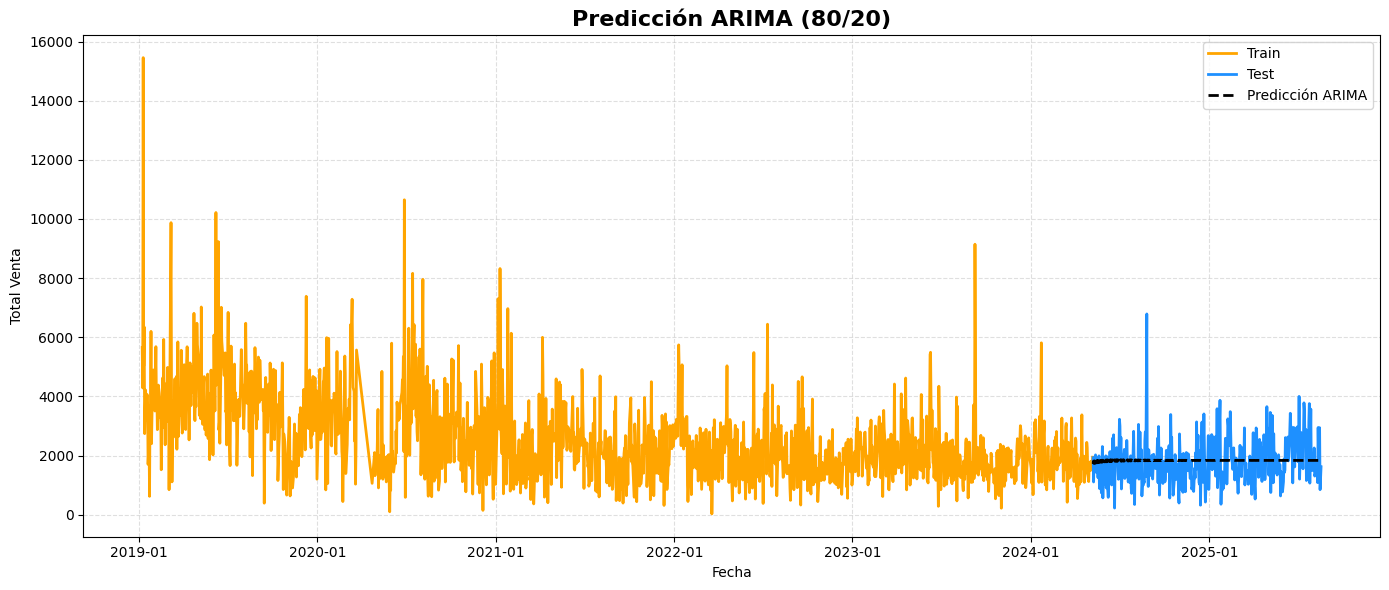

In [163]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train['fecha'], train['monto_recibido'], label='Train', color=color_train, linewidth=2)
ax.plot(test['fecha'], test['monto_recibido'], label='Test', color=color_test, linewidth=2)
ax.plot(test['fecha'], pred_test, '--', label='Predicción ARIMA', color=color_pred, linewidth=2)

ax.set_title("Predicción ARIMA (80/20)", fontsize=16, fontweight='bold')
ax.set_xlabel("Fecha")
ax.set_ylabel("Total Venta")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.legend()
ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

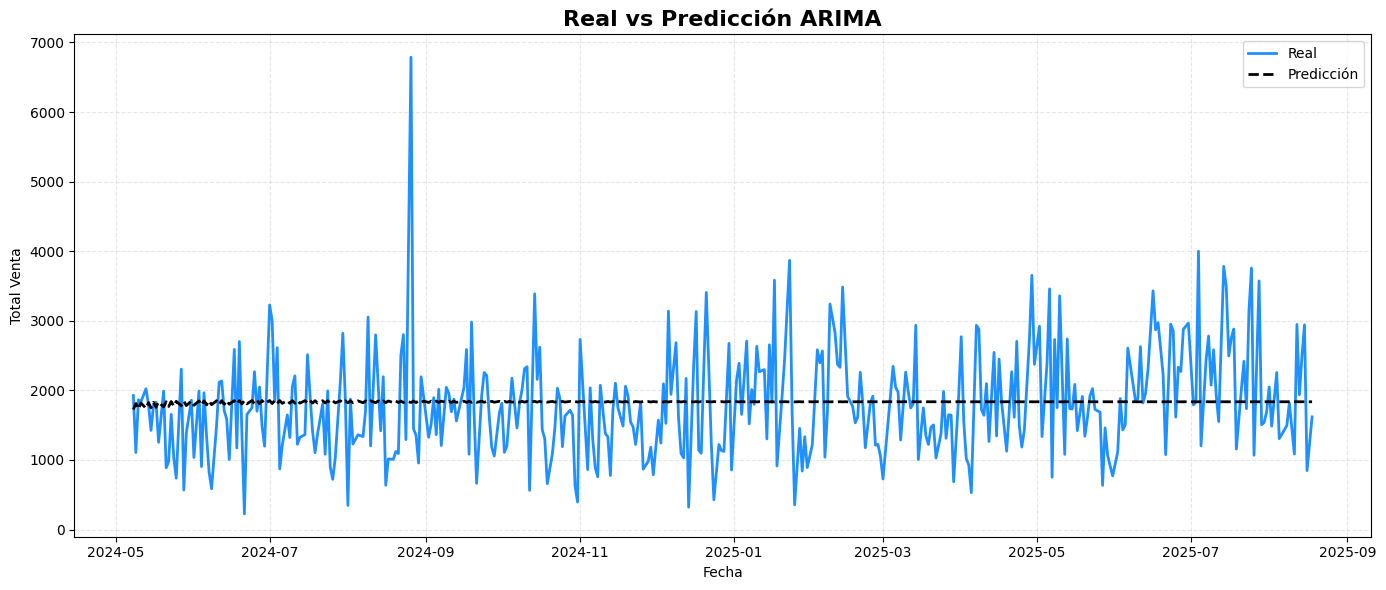

In [164]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test['fecha'], test['monto_recibido'], label='Real', color=color_test, linewidth=2)
ax.plot(test['fecha'], pred_test, '--', label='Predicción', color=color_pred, linewidth=2)

ax.set_title("Real vs Predicción ARIMA", fontsize=16, fontweight='bold')
ax.set_xlabel("Fecha")
ax.set_ylabel("Total Venta")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

ax.legend()
ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

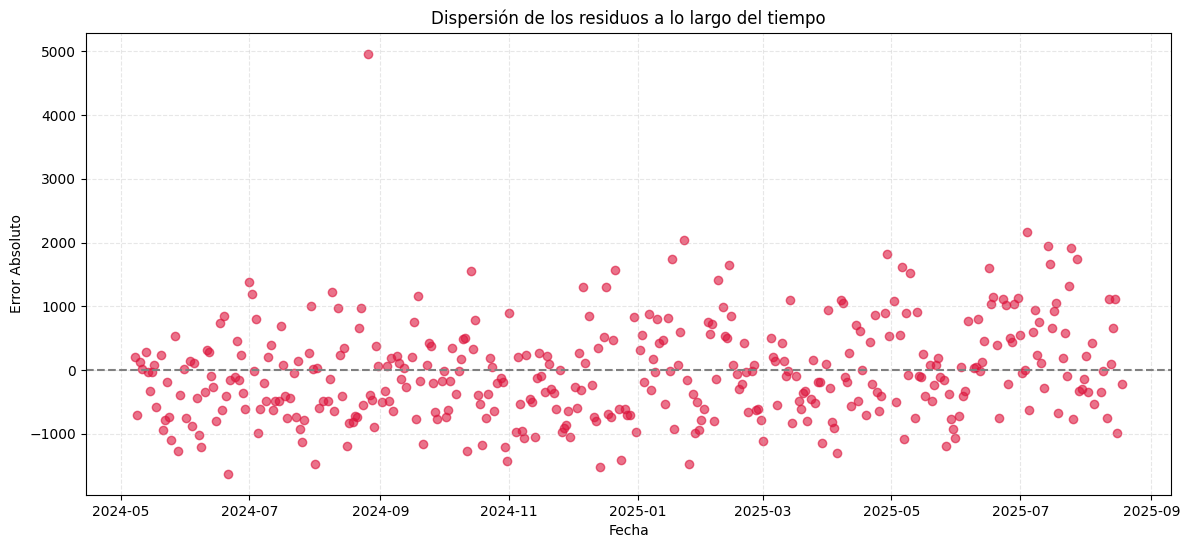

In [165]:
residuos = test['monto_recibido'] - pred_test

plt.figure(figsize=(14,6))
plt.scatter(test['fecha'], residuos, alpha=0.6, color='crimson')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Dispersión de los residuos a lo largo del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Error Absoluto")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

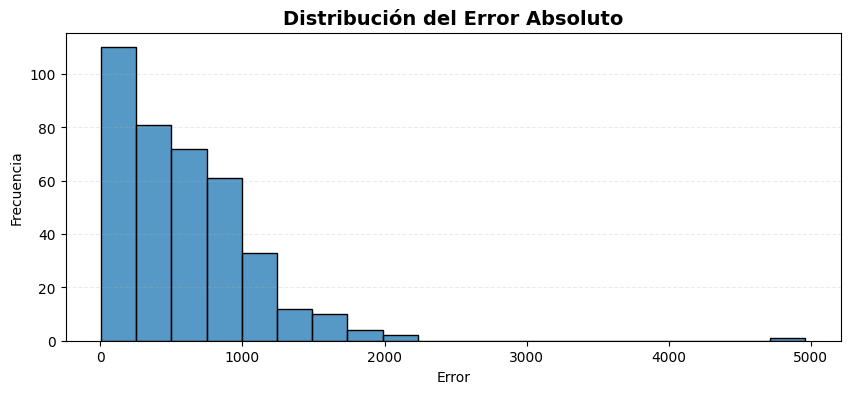

In [166]:
plt.figure(figsize=(10,4))
sns.histplot(abs(residuos), bins=20, color='#1f77b4', edgecolor='black')
plt.title('Distribución del Error Absoluto', fontsize=14, weight='bold')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

In [167]:
df_pred = pd.DataFrame({
    'fecha': test['fecha'].values,
    'real': test['monto_recibido'].values,
    'prediccion': pred_test
})

df_pred.to_csv(f"../output/prediccion_arima.csv", index=False)
print(f"Predicción exportada: prediccion_arima.csv")

Predicción exportada: prediccion_arima.csv


In [169]:
df_pred.head(10)

,fecha,real,prediccion
1544,2024-05-08,1925.0,1724.563295
1545,2024-05-09,1107.0,1812.158344
1546,2024-05-10,1864.0,1734.013391
1547,2024-05-11,1835.6,1818.646451
1548,2024-05-13,2023.0,1742.456587
1549,2024-05-14,1796.0,1824.259484
1550,2024-05-15,1425.0,1750.008633
1551,2024-05-16,1794.6,1829.104059
1552,2024-05-17,1830.5,1756.771698
1553,2024-05-18,1253.5,1833.274098
